<a href="https://colab.research.google.com/github/AAA123404/Financial-big-data-analysis/blob/main/week11%E4%BD%9C%E6%A5%AD_%E5%A4%9A%E6%A8%A1%E6%85%8B_Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import time
from datetime import date
import re
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import pickle as pk
from gensim.models import Word2Vec
import logging
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')

In [4]:
def data2change(data):
    change = pd.DataFrame(data).pct_change()
    change = change.replace([np.inf, -np.inf], np.nan)
    change = change.fillna(0.).values.tolist()
    change = [c[0] for c in change]
    return change

In [5]:
def load_text_csv(filename = '/content/drive/MyDrive/金融/week11/Combined_News_DJIA.csv', date_split = date(2014,12,31)):
  df = pd.read_csv(filename)

  df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)
  date_split = pd.to_datetime(date_split)
  train = df.loc[(pd.to_datetime(df["Date"]) <= date_split),['Label','Combined']]
  test = df.loc[(pd.to_datetime(df["Date"]) > date_split),['Label','Combined']]

  return train, test

In [6]:
train, test = load_text_csv()

In [7]:
def load_ts_csv(filename = '/content/drive/MyDrive/金融/week11/DJIA_table.csv', date_split = date(2014,12,31)):
  data_original = pd.read_csv(filename)[::-1]
  data_original["Date"] = pd.to_datetime(data_original["Date"], format='%d-%m-%Y')
  date_split = pd.to_datetime(date_split)

  train2 = data_original.loc[(pd.to_datetime(data_original["Date"]) <= date_split)]
  test2 = data_original.loc[(pd.to_datetime(data_original["Date"]) > date_split)]

  open_train = train2.loc[:, 'Open']
  open_test = test2.loc[:, 'Open']

  high_train = train2.loc[:, 'High']
  high_test = test2.loc[:, 'High']

  low_train = train2.loc[:, 'Low']
  low_test = test2.loc[:, 'Low']

  close_train = train2.loc[:, 'Close']
  close_test = test2.loc[:, 'Close']

  volume_train = train2.loc[:, 'Volume']
  volume_test = test2.loc[:, 'Volume']

  open_train = data2change(open_train)
  open_test = data2change(open_test)

  high_train = data2change(high_train)
  high_test = data2change(high_test)

  low_train = data2change(low_train)
  low_test = data2change(low_test)

  close_test = data2change(close_test)
  close_train = data2change(close_train)

  volume_train = data2change(volume_train)
  volume_test = data2change(volume_test)

  train = np.column_stack((open_train, high_train, low_train, close_train, volume_train))
  test = np.column_stack((open_test, high_test, low_test, close_test, volume_test))

  print(train.shape)
  print(test.shape)

  return train, test


In [8]:
data_chng_train, data_chng_test = load_ts_csv()

(1611, 5)
(252, 5)


In [9]:
stop_words = set(stopwords.words('english'))
def text_process(text):
    if pd.isnull(text):
        return ""
    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed = tokenizer.tokenize(text)

    # 去除停用詞
    text_processed = [word.lower() for word in text_processed if word.lower() not in stop_words]

    # 詞幹處理
    porter_stemmer = PorterStemmer()
    text_processed = [porter_stemmer.stem(word) for word in text_processed]

    # 移除 'b' 這樣的詞
    text_processed = [word for word in text_processed if word != 'b']

    return " ".join(text_processed)


In [10]:
def transform_text2sentences(train, test, save_train = '/content/drive/MyDrive/金融/week11/train_text.p', save_test = '/content/drive/MyDrive/金融/week11/test_text.p'):

	train_text = []
	test_text = []
	for each in train['Combined']:
	    train_text.append(text_process(each))
	for each in test['Combined']:
	    test_text.append(text_process(each))

	if save_train != None: pk.dump(train_text, open(save_train, 'wb'))
	if save_test != None: pk.dump(test_text, open(save_test, 'wb'))

	return train_text, test_text

In [ ]:
transform_text2sentences(train,test)

In [12]:
import numpy as np
from gensim.models import Word2Vec

def transform_text_into_vectors(train_text, test_text, embedding_size=100, model_path='word2vec10.model'):
    data_for_w2v = []
    for text in train_text + test_text:
        words = text.split(' ')
        data_for_w2v.append(words)

    # 訓練 Word2Vec 模型
    model = Word2Vec(data_for_w2v, vector_size=embedding_size, window=5, min_count=1, workers=4)
    model.save(model_path)

    # 計算文本的向量
    def get_sentence_vector(sentence, model):
        # 將每個單詞轉換為向量，並處理不在詞彙表中的單詞
        sentence_vectors = []
        for word in sentence.split(' '):
            if word in model.wv:
                sentence_vectors.append(model.wv[word])
        if sentence_vectors:
            return np.mean(sentence_vectors, axis=0)
        else:
            return np.zeros(model.vector_size)

    train_text_vectors = [get_sentence_vector(sentence, model) for sentence in train_text]
    test_text_vectors = [get_sentence_vector(sentence, model) for sentence in test_text]

    return train_text_vectors, test_text_vectors, model


In [13]:
train_text = pk.load(open('/content/drive/MyDrive/金融/week11/train_text.p', 'rb'))[1:]
test_text = pk.load(open('/content/drive/MyDrive/金融/week11/test_text.p', 'rb'))[1:]

train_text_vectors, test_text_vectors, model = transform_text_into_vectors(train_text, test_text, 100)

In [14]:
def split_into_XY(data_chng_train, train_text_vectors, step, window, forecast):
    X_train, X_train_text, Y_train, Y_train2 = [], [], [], []
    for i in range(0, len(data_chng_train), step):
        try:
            if i + window + forecast >= len(data_chng_train):
                continue

            x_i = data_chng_train[i:i+window]
            y_i = np.std(data_chng_train[i:i+window+forecast][3]) #close

            text_average = train_text_vectors[i:i+window]
            last_close = x_i[-1]

            y_i2 = None
            if data_chng_train[i+window+forecast][3] > 0.:
                y_i2 = 1.
            else:
                y_i2 = 0.

        except IndexError as e:
            print('IndexError:', e)
            continue

        except Exception as e:
            print('Error:', e)
            continue

        X_train.append(x_i)
        X_train_text.append(text_average)
        Y_train.append(y_i)
        Y_train2.append(y_i2)

    X_train, X_train_text, Y_train, Y_train2 = np.array(X_train), np.array(X_train_text), np.array(Y_train), np.array(Y_train2)
    return X_train, X_train_text, Y_train, Y_train2


In [15]:
X_train, X_train_text, Y_train, Y_train2 = split_into_XY(data_chng_train, train_text_vectors, 1, 30, 1)
X_test, X_test_text, Y_test, Y_test2 = split_into_XY(data_chng_test, test_text_vectors, 1, 30, 1)


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

In [16]:
print(X_train.shape)
print(X_train_text.shape)
print(Y_train.shape)
print(Y_train2.shape)

(1580, 30, 5)
(1580, 30, 100)
(1580,)
(1580,)


In [17]:
print(X_test.shape)
print(X_test_text.shape)
print(Y_test.shape)
print(Y_test.shape)

(221, 30, 5)
(221, 30, 100)
(221,)
(221,)


In [18]:
print(Y_train)

[0.02542046 0.05076908 0.13608661 ... 0.0138336  0.0963691  0.06242205]


#訓練

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, LeakyReLU, Dropout, Flatten, concatenate
from tensorflow.keras.optimizers import Adam

main_input = Input(shape=(30, 5), name='ts_input')
text_input = Input(shape=(30, 100), name='text_input')

lstm1 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(main_input)
lstm1 = LSTM(10, return_sequences=False, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(lstm1)
lstm1 = Flatten()(lstm1)

lstm2 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(text_input)
lstm2 = LSTM(10, return_sequences=False, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(lstm2)
lstm2 = Flatten()(lstm2)

lstms = concatenate([lstm1, lstm2])

x1 = Dense(64)(lstms)
x1 = LeakyReLU()(x1)
x1 = Dense(1, activation='linear', name='regression')(x1)

x2 = Dense(64)(lstms)
x2 = LeakyReLU()(x2)
x2 = Dropout(0.9)(x2)
x2 = Dense(1, activation='sigmoid', name='class')(x2)

final_model = Model(inputs=[main_input, text_input], outputs=[x1, x2])


final_model.compile(optimizer=Adam(), loss={'regression': 'mse', 'class': 'binary_crossentropy'}, metrics={'regression': 'mae', 'class': 'accuracy'})

final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ts_input (InputLayer)     │ (None, 30, 5)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_input (InputLayer)   │ (None, 30, 100)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 30, 10)         │            640 │ ts_input[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 30, 10)         │          4,440 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 10)             │            840 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 10)             │            840 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 10)             │              0 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 10)             │              0 │ lstm_7[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 20)             │              0 │ flatten_2[0][0],       │
│ (Concatenate)             │                        │                │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          1,344 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          1,344 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 64)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regression (Dense)        │ (None, 1)              │             65 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class (Dense)             │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,578 (37.41 KB)

 Trainable params: 9,578 (37.41 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(monitor='val_loss',
                               filepath="/content/drive/MyDrive/金融/week11/model.keras",
                               verbose=1,
                               save_best_only=True)

opt = Nadam(learning_rate=0.0002, clipnorm=0.5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=1)

final_model.compile(optimizer=opt,
                    loss={'regression': 'mse', 'class': 'binary_crossentropy'},
                    loss_weights={'regression': 1., 'class': 0.2})


In [25]:
history = final_model.fit(
    [X_train, X_train_text],
    [Y_train, Y_train2],
    epochs=100,
    batch_size=256,
    verbose=1,
    validation_data=([X_test, X_test_text], [Y_test, Y_test2]),
    callbacks=[reduce_lr, checkpointer],
    shuffle=True
)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - class_loss: 0.3353 - loss: 1.9588 - regression_loss: 1.6114
Epoch 1: val_loss improved from inf to 0.69134, saving model to /content/drive/MyDrive/金融/week11/model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 336ms/step - class_loss: 0.3344 - loss: 1.9240 - regression_loss: 1.5683 - val_class_loss: 0.2508 - val_loss: 0.6913 - val_regression_loss: 0.4406 - learning_rate: 2.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - class_loss: 0.3268 - loss: 0.8622 - regression_loss: 0.5306
Epoch 2: val_loss improved from 0.69134 to 0.52726, saving model to /content/drive/MyDrive/金融/week11/model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - class_loss: 0.3251 - loss: 0.8526 - regression_loss: 0.5192 - val_class_loss: 0.2500 - val_loss: 0.5273 - val_regression_loss: 0.2772 - learning_rate: 2.0000e-04
Epoch 3/100
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - class_loss: 0.3198 - loss: 0.5826 - regression_loss: 0.2628
Epoch 3: val_loss improved from 0.5

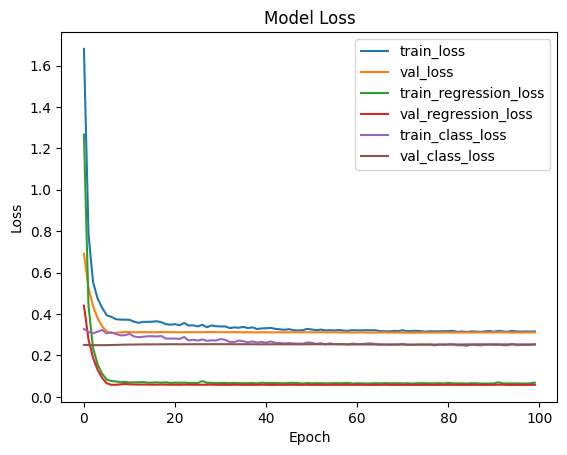

In [26]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.plot(history.history['regression_loss'], label='train_regression_loss')
plt.plot(history.history['val_regression_loss'], label='val_regression_loss')
plt.plot(history.history['class_loss'], label='train_class_loss')
plt.plot(history.history['val_class_loss'], label='val_class_loss')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()
